# BERT
Use bert and \<CLS> token vector for classification

## Dependencies

In [1]:
# BASIC
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# DATA
from data.process_data import load_train_data, load_test_data, load_data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate

# MODEL
import torch
from torch import nn
import torch.nn.functional as F
from transformers import BertForSequenceClassification, AdamW
from transformers import AdamW, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
from transformers import BertTokenizer

# EVALUATIONS
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
# helper function
def plot_cm(y_test, y_test_pred, name, labels=[1, 2, 3, 4, 5]):
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm_df, annot=True, cmap=plt.get_cmap('Blues'), fmt="d")
    plt.title("Confusion Matrix of " + name)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

## Prepare Data

In [3]:
%%time
X_train, X_test, y_train, y_test = load_data()

CPU times: user 2min 21s, sys: 532 ms, total: 2min 22s
Wall time: 2min 22s


In [4]:
# %%time
# X_test, y_test = load_test_data()
# X_train, y_train = load_train_data()

In [5]:
class Toxic_dataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len=128):

        self.labels = torch.tensor(y)

        self.encodings = tokenizer(
            X,
            truncation = True,
            padding = True,
            max_length = max_len,
            return_tensors = 'pt'
        )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
        
        return item

In [6]:
%%time
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# train dataloader
train_dataset = Toxic_dataset(X_train.tolist(), y_train, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test dataloader
test_dataset = Toxic_dataset(X_test.tolist(), y_test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

CPU times: user 30.8 s, sys: 52 ms, total: 30.8 s
Wall time: 31.1 s


## Construct Model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased').to(device)
for param in model.bert.parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True
optimizer = AdamW(model.parameters(), lr=2e-5)
# Training function
def train_epoch(data_loader, model, optimizer):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    model.train()
    train_loss, correct = 0, 0
    for batch in data_loader:
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Compute prediction error
        outputs = model(
            input_ids,
            attention_mask = attention_mask,
            labels = labels
        )
        loss = outputs.loss
        train_loss += loss.item()
        pred = outputs.logits
        correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

def eval_epoch(data_loader, model, optimizer):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    model.eval()
    eval_loss = 0
    correct = 0
    for batch, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Compute prediction error
        outputs = model(
            input_ids,
            attention_mask = attention_mask,
            labels = labels
        )

        # Compute prediction error
        pred = outputs.logits
        loss = outputs.loss
        eval_loss += loss.item()
        correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    average_eval_loss = eval_loss / num_batches
    accuracy = correct / size
    return accuracy, average_eval_loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/keyulong/miniconda3/envs/CSE256/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
all_train_accuracy = []
all_test_accuracy = []
best_model = None
train_accuracy, train_loss = train_epoch(train_dataloader, model, optimizer)
all_train_accuracy.append(train_accuracy)

print(f'train accuracy {train_accuracy:.3f}')

train accuracy 0.920


## Evaluate the Result

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
def make_predictions(model, loader):
    model.eval()
    y_test_pred = []
    y_true = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(
                input_ids,
                attention_mask = attention_mask
            )
            _, preds = torch.max(outputs.logits, 1)
            y_test_pred.append(preds.cpu().numpy())
            
    return np.concatenate(y_test_pred)

In [10]:
%%time
y_train_pred = make_predictions(model, train_dataloader)
y_test_pred = make_predictions(model, test_dataloader)

CPU times: user 1min 40s, sys: 55.4 ms, total: 1min 40s
Wall time: 1min 40s


In [11]:
# train acc
accuracy_score(y_train, y_train_pred)

0.9655039655039656

In [12]:
# test acc
accuracy_score(y_test, y_test_pred)

0.9352044352044352

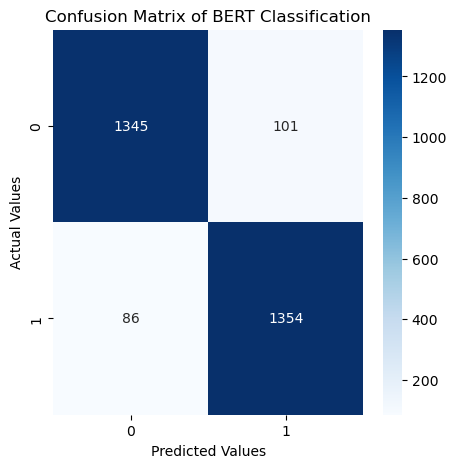

In [13]:
plot_cm(y_test, y_test_pred, "BERT Classification", [0, 1])